## Import relevant modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

In [53]:
# Option to display more columns of a data frame
pd.set_option("display.max_columns", 40)

## Load airbnb data for Boston and have a look

In [46]:
# Paths to the files
path1 = r"./Airbnb Boston Data/calendar.csv"
path2 = r"./Airbnb Boston Data/listings.csv"
path3 = r"./Airbnb Boston Data/reviews.csv"

path4 = r"./Airbnb Seattle Data/calendar.csv"
path5 = r"./Airbnb Seattle Data/listings.csv"
path6 = r"./Airbnb Seattle Data/reviews.csv"

# Load each file and add city as a column where necessary
df_calendar_boston = pd.read_csv(path1, sep = ",")
df_calendar_boston['city'] = 'Boston'
df_listings_boston = pd.read_csv(path2, sep = ",")
df_reviews_boston = pd.read_csv(path3, sep = ",")
df_reviews_boston['city'] = 'Boston'

df_calendar_seattle = pd.read_csv(path4, sep = ",")
df_calendar_seattle['city'] = 'Seattle'
df_listings_seattle = pd.read_csv(path5, sep = ",")
df_reviews_seattle = pd.read_csv(path3, sep = ",")
df_reviews_seattle['city'] = 'Seattle'

# Concatenate the data frames for the two cities for each dataset
df_calendar = pd.concat([df_calendar_boston, df_calendar_seattle])
df_listings = pd.concat([df_listings_boston, df_listings_seattle])
df_reviews = pd.concat([df_reviews_boston, df_reviews_seattle])

In [22]:
df_calendar_boston.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

# Data cleaning

In [47]:
# Look at first rows of calendar
df_calendar.head()

,listing_id,date,available,price,city
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston


In [44]:
# dtypes of calendar
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
city          object
dtype: object

In [45]:
# Look at values for 'available'
df_calendar.available.unique()

array(['f', 't'], dtype=object)

### The values for available consist only of 'f' and 't' without missing values. Thus 'available' can be converted to boolian

In [25]:
# convert 'date' to date format, 'available' to boolian and 'price' to float
df_calendar['date'] = pd.to_datetime(df_calendar.date, errors = 'coerce')
df_calendar['available'] = df_calendar['available'].apply(lambda x: 0 if x.strip() == 'f' else 1).astype('bool')
df_calendar['price'] = df_calendar['price'].str.replace(r"[\$,]", "", regex = True).astype('float')

In [27]:
# Percentage of missing values for each column in calendar
df_calendar.isna().mean().sort_values(ascending = False)

price         0.416243
listing_id    0.000000
date          0.000000
available     0.000000
city          0.000000
dtype: float64

In [48]:
# Look at first rows of listings
df_listings.head(4)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00


In [51]:
# string columns in listings
df_listings.select_dtypes(include = 'object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'ha

In [54]:
# Look at string columns I suppose to be not string
df_listings.loc[:,['host_since', 'host_response_time', 'host_response_rate',
                   'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
                   'host_identity_verified', 'is_location_exact', 'price', 'weekly_price',
                   'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
                   'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review',
                   'last_review', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                   'require_guest_phone_verification'
                  ]].head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,2015-04-15,NaN,NaN,NaN,f,t,f,t,$250.00,NaN,NaN,NaN,$35.00,$0.00,2 weeks ago,NaN,2016-09-06,NaN,NaN,f,f,f,f
1,2012-06-07,within an hour,100%,100%,f,t,t,t,$65.00,$400.00,NaN,$95.00,$10.00,$0.00,a week ago,NaN,2016-09-06,2014-06-01,2016-08-13,f,t,f,f
2,2009-05-11,within a few hours,100%,88%,t,t,t,t,$65.00,$395.00,"$1,350.00",NaN,NaN,$20.00,5 days ago,NaN,2016-09-06,2009-07-19,2016-08-05,f,f,t,f
3,2013-04-21,within a few hours,100%,50%,f,t,f,f,$75.00,NaN,NaN,$100.00,$50.00,$25.00,a week ago,NaN,2016-09-06,2016-08-28,2016-08-28,f,f,f,f
4,2014-05-11,within an hour,100%,100%,t,t,t,t,$79.00,NaN,NaN,NaN,$15.00,$0.00,2 weeks ago,NaN,2016-09-06,2015-08-18,2016-09-01,f,f,f,f


### It seems I was only wrong with 'host_response_time'. Also 'calendar_updated' seems not so handy. One could consider to split it into the numeric part and in a field containing the unit of measurement.

In [56]:
# Check if potential boolian fields have missing values
df_listings.loc[:, ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
           'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
           'require_guest_phone_verification'
          ]].isna().mean().sort_values(ascending = False)

host_is_superhost                   0.00027
host_has_profile_pic                0.00027
host_identity_verified              0.00027
is_location_exact                   0.00000
requires_license                    0.00000
instant_bookable                    0.00000
require_guest_profile_picture       0.00000
require_guest_phone_verification    0.00000
dtype: float64

In [ ]:
# I have to consider missing values when I convert the fields

In [ ]:
# Convert data types
# dates
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'], errors = 'coerce')
df_listings['calendar_last_scraped'] = pd.to_datetime(df_listings['calendar_last_scraped'], errors = 'coerce')
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors = 'coerce')
df_listings['last_review'] = pd.to_datetime(df_listings['last_review'], errors = 'coerce')
# boolian
df_listings['host_is_superhost'] = df_listings['host_is_superhost'].apply(lambda x: 0 if x.strip() == 'f' else 1).astype('bool')

In [31]:
# Percentage of missing values in listings
df_listings.isna().mean().sort_values(ascending = False)

license            1.000000
square_feet        0.979333
interaction        0.725652
access             0.716872
house_rules        0.676753
                     ...   
bed_type           0.000000
amenities          0.000000
price              0.000000
guests_included    0.000000
country            0.000000
Length: 95, dtype: float64

In [32]:
# First rows of listings
df_listings.head(10)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25
5,12386020,https://www.airbnb.com/rooms/12386020,20160906204935,2016-09-07,Private Bedroom + Great Coffee,Super comfy bedroom plus your own bathroom in ...,Our sunny condo is located on the second and t...,Super comfy bedroom plus your own bathroom in ...,none,We love our corner of Roslindale! For quiet wa...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.70
6,5706985,https://www.airbnb.com/rooms/5706985,20160906204935,2016-09-07,New Lrg Studio apt 15 min to Boston,It's a 5 minute walk to Rosi Square to catch t...,The whole house was recently redone and it 's ...,It's a 5 minute walk to Rosi Square to catch t...,none,Roslindale is the new hip area of Boston. Clos...,...,9.0,f,NaN,NaN,f,strict,f,f,3,4.00
7,2843445,https://www.airbnb.com/rooms/2843445,20160906204935,2016-09-07,"""Tranquility"" on ""Top of the Hill""","We can accommodate guests who are gluten-free,...",We provide a bedroom and full shared bath. Ra...,"We can accommodate guests who are gluten-free,...",none,Our neighborhood is residential with friendly ...,...,10.0,f,NaN,NaN,f,moderate,t,t,2,2.38
8,753446,https://www.airbnb.com/rooms/753446,20160906204935,2016-09-07,6 miles away from downtown Boston!,Nice and cozy apartment about 6 miles away to ...,Nice and cozy apartment about 6 miles away to ...,Nice and cozy apartment about 6 miles away to ...,none,Roslindale is a primarily residential neighbor...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,5.36
9,849408,https://www.airbnb.com/rooms/849408,20160906204935,2016-09-07,Perfect & Practical Boston Rental,This is a cozy and spacious two bedroom unit w...,Perfect apartment rental for those in town vis...,This is a cozy and spacious two bedroom unit w...,none,"This neighborhood truly has it all. Good, not...",...,9.0,f,NaN,NaN,f,strict,f,f,2,1.01


In [33]:
# Since the field license is always missing we can drop it
df_listings = df_listings.drop(columns = ['license'])

In [30]:
# Distribution of review score values in listings
df_listings.review_scores_value.value_counts().sort_values(ascending = False)

10.0    2952
9.0     2267
8.0      524
7.0       89
6.0       65
4.0       16
2.0        8
5.0        3
3.0        2
Name: review_scores_value, dtype: int64

In [34]:
df_listings.cancellation_policy.unique()

array(['moderate', 'flexible', 'strict', 'super_strict_30'], dtype=object)

In [35]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,Boston
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,Boston
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,Boston
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,Boston
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,Boston


In [36]:
df_reviews.isna().mean().sort_values(ascending = False)

comments         0.000776
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
city             0.000000
dtype: float64

### mean price per listing_id

In [37]:
df_calendar.groupby(['listing_id']).price.mean().sort_values(ascending = False)

listing_id
12972378    4000.000000
8303267     1724.624625
14798673    1345.000000
3308979     1301.818182
10882267    1250.000000
               ...     
14673441            NaN
14722711            NaN
14774868            NaN
14809866            NaN
14852273            NaN
Name: price, Length: 7403, dtype: float64

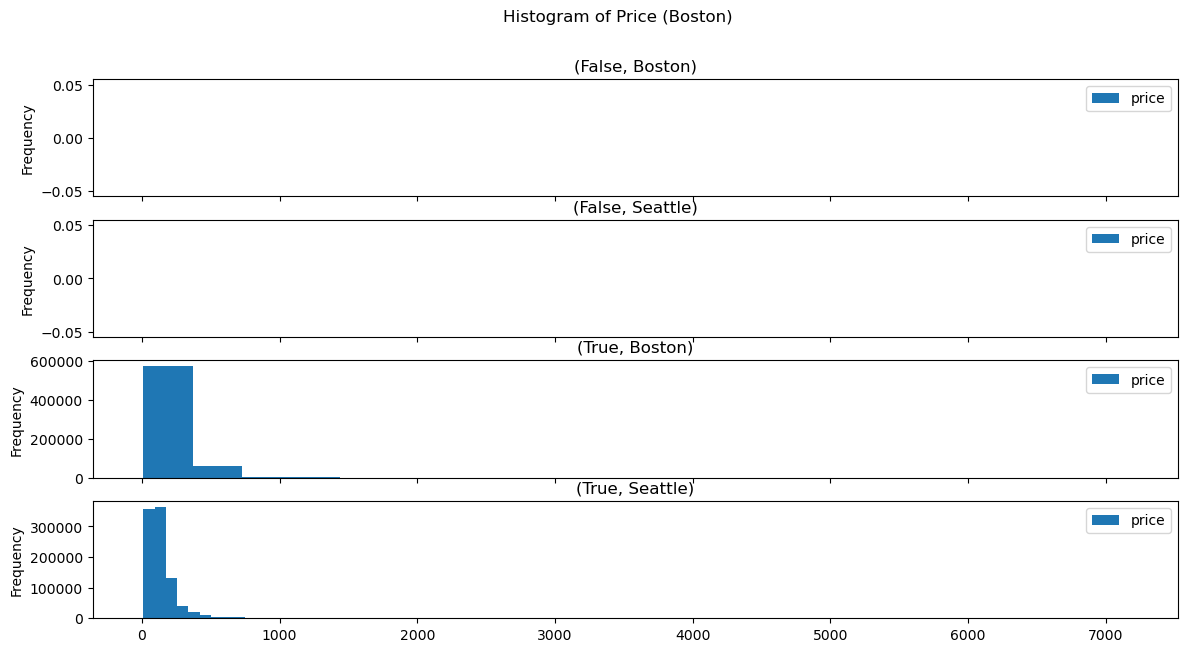

In [41]:
df_calendar.plot.hist(column = 'price', by = ['available', 'city'], sharex = True, bins = 20, figsize = (14,7), title = "Histogram of Price (Boston)");

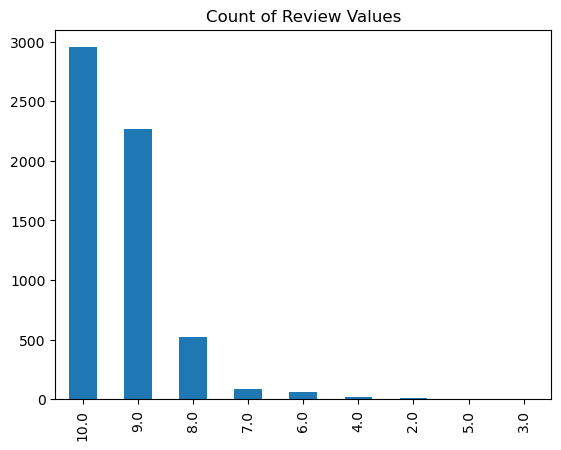

In [42]:
df_listings.review_scores_value.value_counts().sort_values(ascending = False).plot.bar(title = 'Count of Review Values');